In [18]:
from __future__ import division
from astropy.io import fits
import os
import glob
import copy
import numpy as np
from astropy.table import Table, Column
import astropy.wcs as wcs
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from astropy.io import ascii
import sys

# masking
from kungpao import imtools
import sep
import matplotlib.pyplot as plt
import copy

sep.set_extract_pixstack(30000000)
from IPython.display import clear_output

# Sample coordinates to get AIRMASS
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

In [2]:
# define path

path = "/home/enzo/135/01"

In [3]:
os.chdir(path)
filename = glob.glob('*')

In [4]:
# time-Airmass

# sample stars
alb = SkyCoord.from_name('Albireo')

zeta_aql = SkyCoord.from_name('Zeta Aquilae')
gama_lyr = SkyCoord.from_name('Sulafat')
beta_apl = SkyCoord.from_name('Alshain')
alp_del = SkyCoord.from_name('Sualocin')
alp_peg = SkyCoord.from_name('Markab')

JBE = EarthLocation(lat=37.005*u.deg, lon=-122.0631*u.deg, height=249*u.m)
utcoffset = -8*u.hour  # Eastern Daylight Time


In [5]:
#time = Time('2018-11-04 20:00:00') - utcoffset
#albaltaz = alb.transform_to(AltAz(obstime=time,location=JBE)).secz
#albaltaz 

In [6]:
timeset = []
exptime = []
band = []
time = []
for name in filename:
    file = fits.open(name)
    hh = int(file[0].header['DATE-OBS'][11:][:2])
    mm = int(file[0].header['DATE-OBS'][11:][3:5])
    ss = int(file[0].header['DATE-OBS'][11:][6:8])
    timeset.append(hh + mm/60 + ss/3600)
    exptime.append(file[0].header['EXPTIME'])
    band.append(file[0].header['FILTER'])
    time_format = str(file[0].header['DATE-OBS'][:10])+" "+str(hh)+':'+str(mm)+':'+str(ss)
    time.append(Time(time_format)-utcoffset)
     

In [7]:
timeset = Column(name='time', data=np.array(timeset), dtype=np.float64)
exptime = Column(name='exptime', data=np.array(exptime))
filename = Column(name='filename', data=filename)
band = Column(name='band', data=band)
airmass = Column(name='airmass', data=alb.transform_to(AltAz(obstime=time,location=JBE)).secz)
catalog = Table([filename, timeset ,exptime, band, airmass])

In [8]:
catalog.sort('band')

In [9]:
catalog['band']=='Blue'

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [10]:
catalog['time'][catalog['band']=='Blue']

20.393055555555556
20.39638888888889
20.390555555555554
19.726388888888888
19.72861111111111
20.854166666666668
20.85777777777778
19.698333333333334
20.875
20.88222222222222
18.981944444444444


In [11]:
def extract_obj(img, b=30, f=5, sigma=5, show_fig=True, pixel_scale=0.168, minarea=5, 
    deblend_nthresh=32, deblend_cont=0.005, clean_param=1.0):
    '''Extract objects for a given image, using `sep`.
    Parameters:
    ----------
    img: 2-D numpy array
    b: float, size of box
    f: float, size of convolving kernel
    sigma: float, detection threshold
    pixel_scale: float
    Returns:
    -------
    objects: numpy array, containing the positions and shapes of extracted objects.
    segmap: 2-D numpy array, segmentation map
    '''

    # Subtract a mean sky value to achieve better object detection
    b = 30  # Box size
    f = 5   # Filter width
    bkg = sep.Background(img, bw=b, bh=b, fw=f, fh=f)
    data_sub = img - bkg.back()

    sigma = sigma
    objects, segmap = sep.extract(data_sub,
                                  sigma,
                                  err=bkg.globalrms,
                                  segmentation_map=True,
                                  filter_type='matched',
                                  deblend_nthresh=deblend_nthresh,
                                  deblend_cont=deblend_cont,
                                  clean=True,
                                  clean_param=clean_param,
                                  minarea=minarea)
                                  
    print("# Detect %d objects" % len(objects))

    # plot background-subtracted image
    if show_fig:
        fig, ax = plt.subplots(1,2, figsize=(12,6))

        ax[0] = display_single(data_sub, ax=ax[0], scale_bar_length=60, pixel_scale=pixel_scale)

        # plot an ellipse for each object
        for obj in objects:
            e = Ellipse(xy=(obj['x'], obj['y']),
                        width=8*obj['a'],
                        height=8*obj['b'],
                        angle=obj['theta'] * 180. / np.pi)
            e.set_facecolor('none')
            e.set_edgecolor('red')
            ax[0].add_artist(e)
        ax[1] = display_single(segmap, scale='linear', cmap=SEG_CMAP , ax=ax[1])
    return objects, segmap


def make_binary_mask(img, w, segmap, radius=10.0, threshold=0.01, gaia=True, factor_b=1.2, show_fig=True):
    '''Make binary mask for a given segmentation map. 
    We convolve the segmentation map using a Gaussian kernal to expand the size of mask.
    Parameters:
    ----------
    img: 2-D numpy array, image data
    w: wcs of the input image
    segmap: 2-D numpy array, segmentation map given by `extract_obj()`
    radius: float, the width of Gaussian kernel
    threshold: float, it can change the size of mask. Lower threshold, larger mask.
    Returns:
    -------
    binary_mask: 2-D numpy boolean array.
    '''

    # Remove the central object
    seg_nocen = imtools.seg_remove_cen_obj(segmap)
    seg_conv = copy.deepcopy(seg_nocen)
    seg_conv[seg_nocen > 0] = 1

    # Convolve the image with a Gaussian kernel with the width of 10 pixel
    # This is actually pretty slow, because the image is very large. 
    seg_conv = convolve(seg_conv.astype('float'), Gaussian2DKernel(radius))
    seg_mask = seg_conv >= threshold

    if gaia is False:
        if show_fig:
            display_single(seg_mask.astype(int), cmap=SEG_CMAP)
        return seg_mask
    else:
        # Combine this mask with Gaia star mask
        gaia_mask = imtools.gaia_star_mask(img, w, gaia_bright=16, factor_f=10000, factor_b=factor_b)[1].astype('bool')
        if show_fig:
        	display_single((seg_mask + gaia_mask).astype(int), cmap=SEG_CMAP)

        binary_mask = seg_mask + gaia_mask
        return binary_mask


In [20]:
intens1_set = []
intens2_set = []
mag1_set = []
mag2_set = []
x = []
y = []
for obj in catalog[catalog['band']=='Blue']:
    clear_output()
    img = fits.open(obj['filename'])[0].data.astype(float)
    w = wcs.WCS(fits.open(obj['filename'])[0].header)
    
    objects, segmap = extract_obj(
            img,
            b=10,
            f=5,
            sigma=5,
            pixel_scale=0.168,
            deblend_cont=0.1,
            deblend_nthresh=20,
            show_fig=False)
    # make mask
    seg_mask = make_binary_mask(img, w, segmap, show_fig=False, gaia=False, threshold=0.1, radius=10)
    bkg = sep.Background(img*(~seg_mask))
    # Aperture photometry
    objects = Table(objects)
    objects.sort('flux')
    objects.reverse()
    flux1 = sep.sum_ellipse(img- bkg.globalback, objects['x'], objects['y'], 31, 31, objects['theta'])[0][0]
    flux2 = sep.sum_ellipse(img- bkg.globalback, objects['x'], objects['y'], 31, 31, objects['theta'])[0][1]
    area1 = (np.pi*objects['a']*objects['b'])[0]
    area2 = (np.pi*objects['a']*objects['b'])[1]
    intens1 = flux1 / obj['exptime']
    intens2 = flux2 / obj['exptime']
    mag1 = -2.5*np.log10(intens1)
    mag2 = -2.5*np.log10(intens2)
    x.append(objects['x'])
    y.append(objects['y'])
    intens1_set.append(intens1)
    intens2_set.append(intens2)
    mag1_set.append(mag1)
    mag2_set.append(mag2)
    

# Detect 2 objects


In [15]:
blue = Table([intens1_set, intens2_set, mag1_set, mag2_set, catalog['airmass'][catalog['band']=='Blue'],catalog['time'][catalog['band']=='Blue'], x, y])

In [21]:
blue.write('Alb_B', format='csv')
blue

TypeError: unhashable type: 'Column'

In [ ]:
plt.scatter(blue['airmass'], blue['col2'])
plt.ylabel('Magnitude')
plt.xlabel('Airmass')
plt.title('Airmass vs. Magnitude of Albireo')

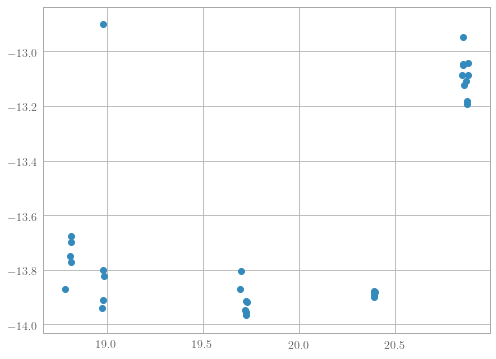

In [138]:
plt.scatter(blue['time'], blue['col2'])